**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Segment Anything Model (SAM) and other dependencies

In [2]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [3]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.3 MB/s eta 0:00:00


### Download SAM weights

In [4]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [5]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Load Model

In [6]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [7]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [8]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
import os

IMAGE_NAME = "/content/Screenshot from 2025-11-28 14-08-24.png"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Generate masks with SAM

In [ ]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [ ]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

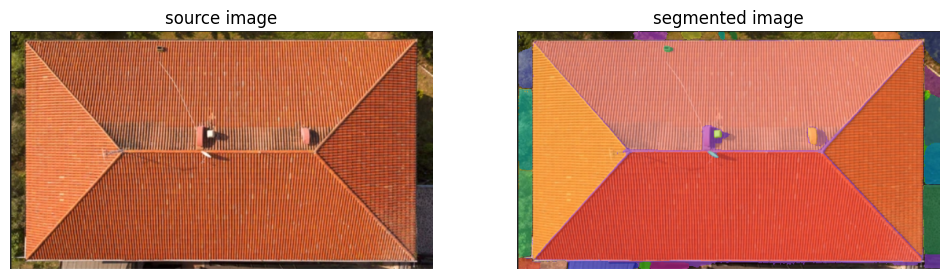

In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

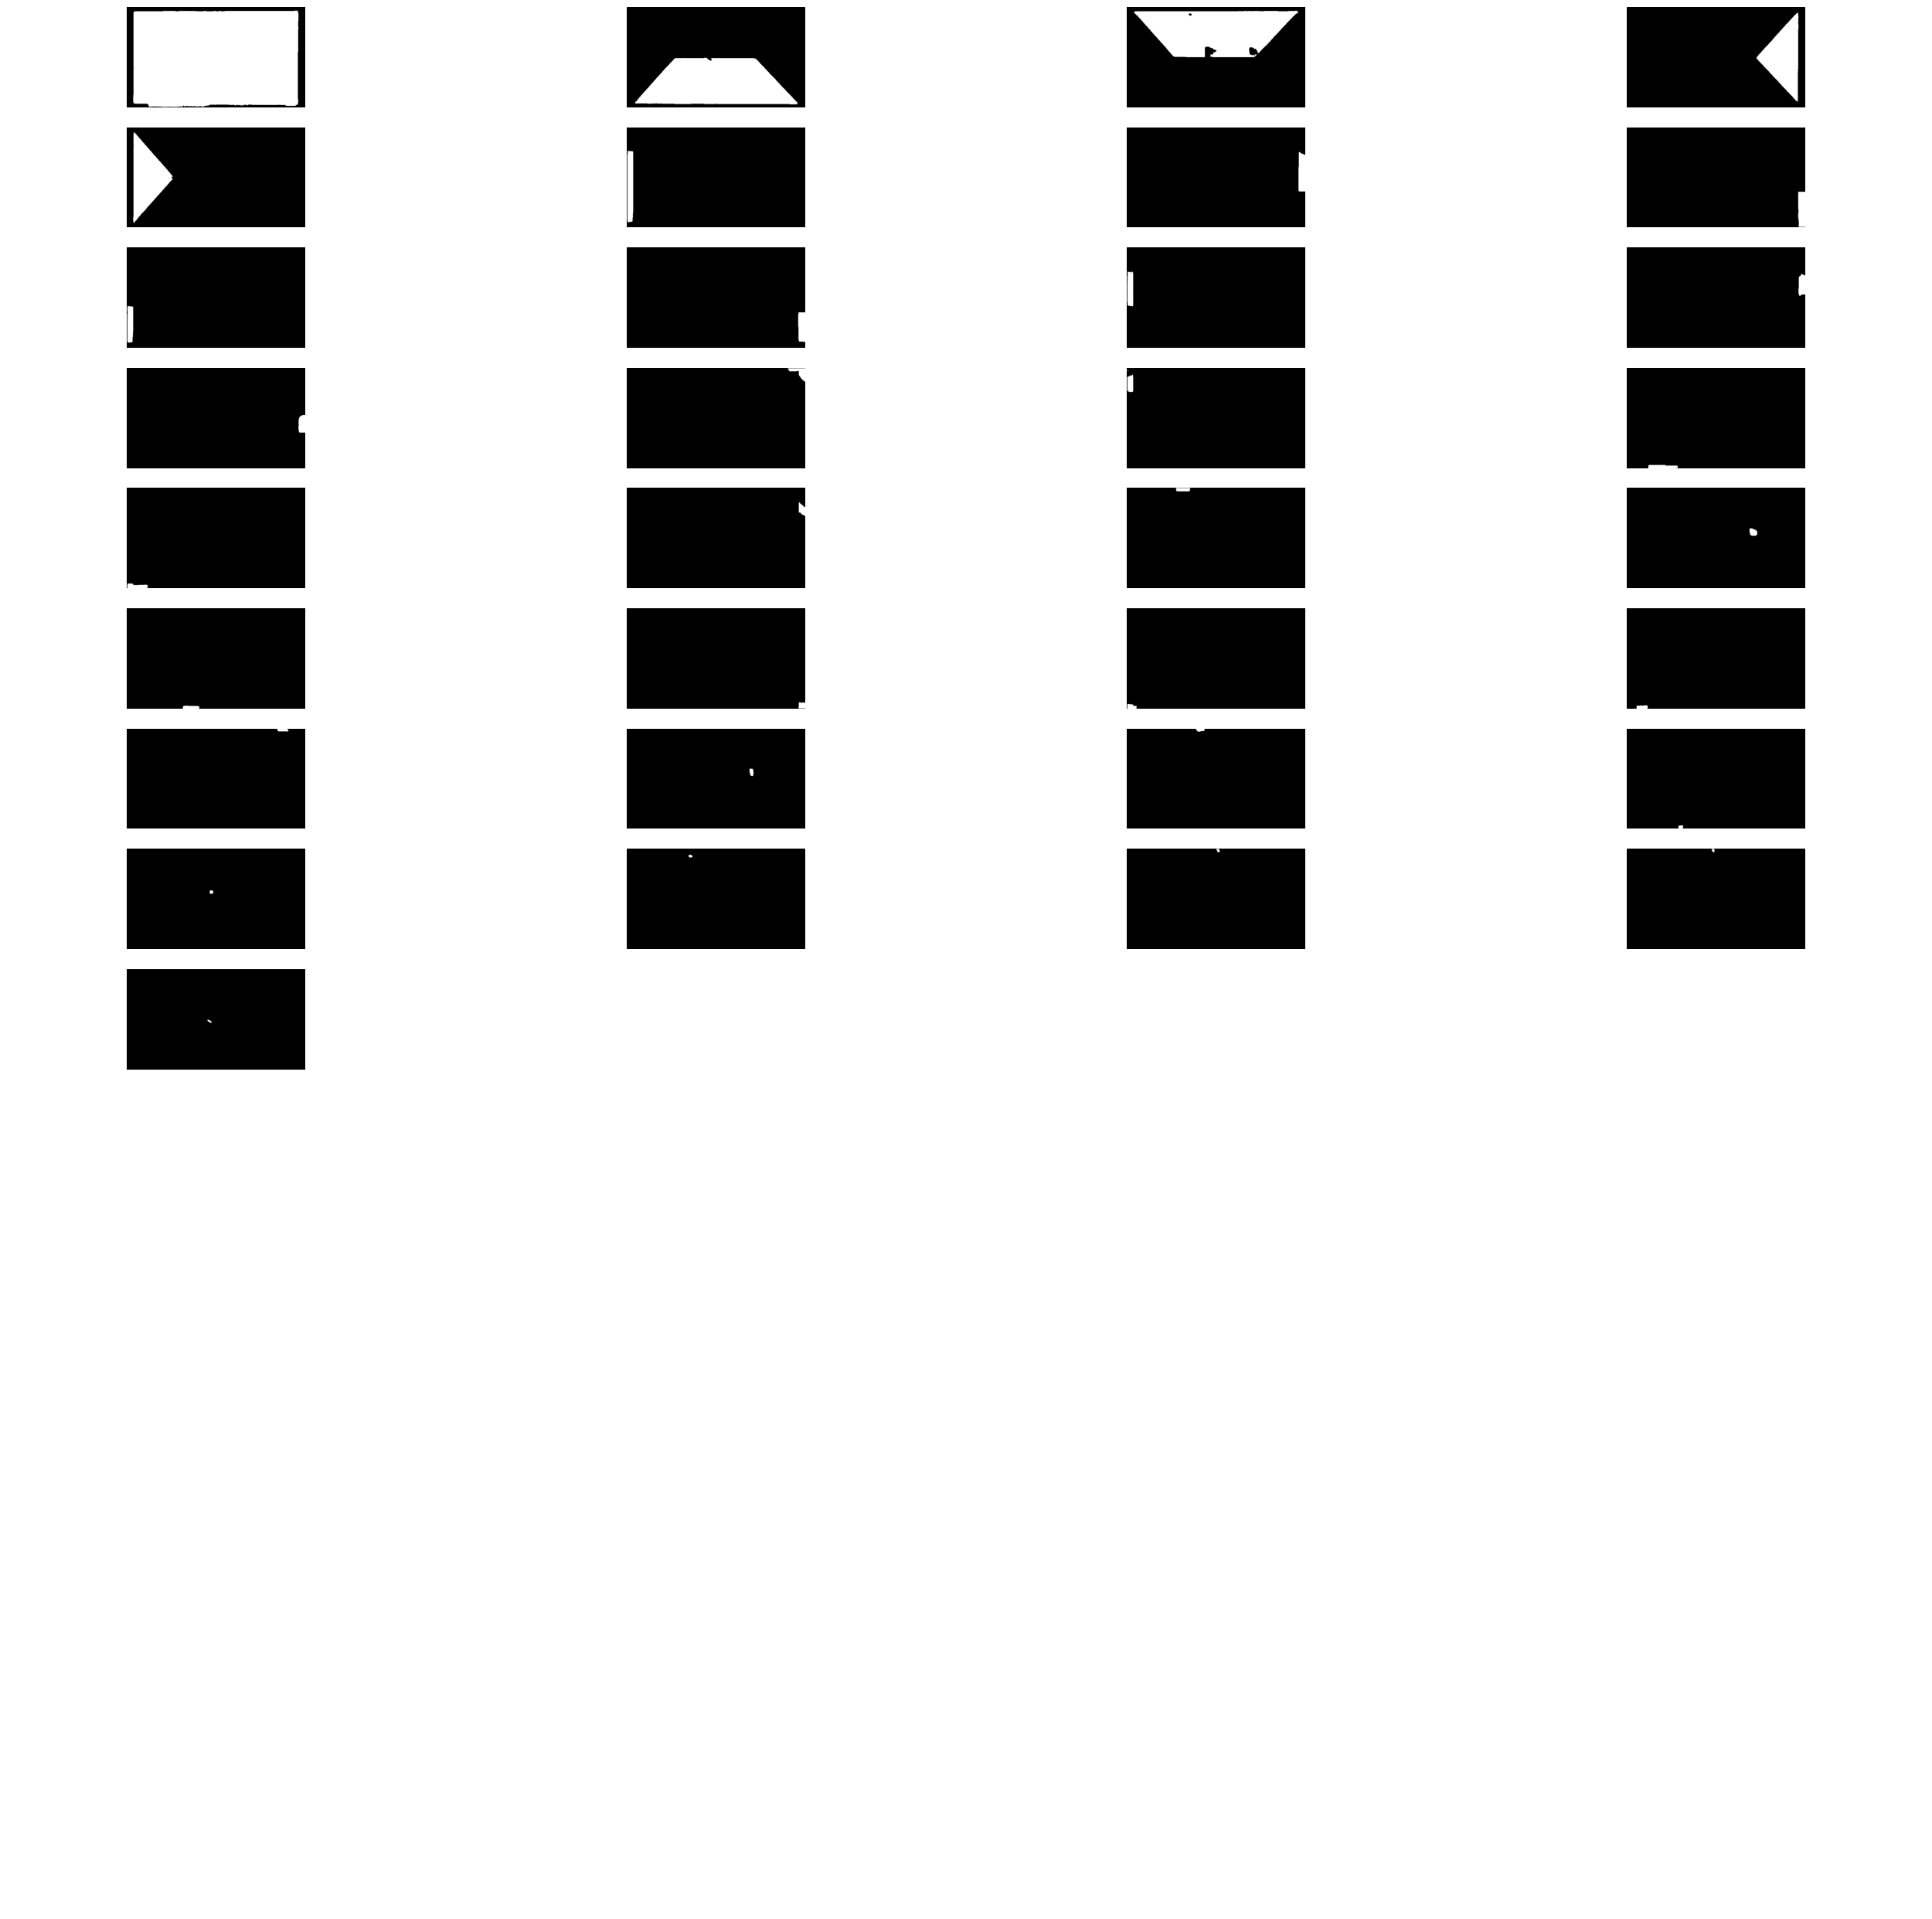

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(16, int(len(masks) / 8)),
    size=(32, 32)
)

In [ ]:
# Sort the results just like you did in your screenshot
sorted_results = sorted(sam_result, key=lambda x: x['area'], reverse=True)

# Loop through and print the area for each
for i, result in enumerate(sorted_results):
    print(f"Mask {i+1}: {result['area']} pixels")

Mask 1: 163694 pixels
Mask 2: 59213 pixels
Mask 3: 58036 pixels
Mask 4: 20286 pixels
Mask 5: 19551 pixels
Mask 6: 4307 pixels
Mask 7: 2664 pixels
Mask 8: 2565 pixels
Mask 9: 2155 pixels
Mask 10: 2128 pixels
Mask 11: 2056 pixels
Mask 12: 1359 pixels
Mask 13: 1164 pixels
Mask 14: 1058 pixels
Mask 15: 984 pixels
Mask 16: 963 pixels
Mask 17: 765 pixels
Mask 18: 635 pixels
Mask 19: 491 pixels
Mask 20: 488 pixels
Mask 21: 484 pixels
Mask 22: 403 pixels
Mask 23: 376 pixels
Mask 24: 372 pixels
Mask 25: 337 pixels
Mask 26: 258 pixels
Mask 27: 251 pixels
Mask 28: 144 pixels
Mask 29: 111 pixels
Mask 30: 92 pixels
Mask 31: 89 pixels
Mask 32: 79 pixels
Mask 33: 71 pixels


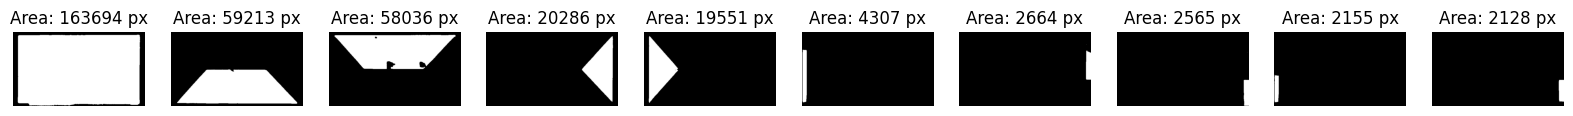

In [ ]:
import matplotlib.pyplot as plt

# Sort results by area (largest first)
sorted_results = sorted(sam_result, key=lambda x: x['area'], reverse=True)

# Let's plot the top 10 largest masks as an example
num_to_plot = min(len(sorted_results), 10)

plt.figure(figsize=(20, 5))

for i in range(num_to_plot):
    mask = sorted_results[i]['segmentation']
    area = sorted_results[i]['area']

    plt.subplot(1, num_to_plot, i+1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Area: {area} px") # displaying area in title
    plt.axis('off')

plt.show()

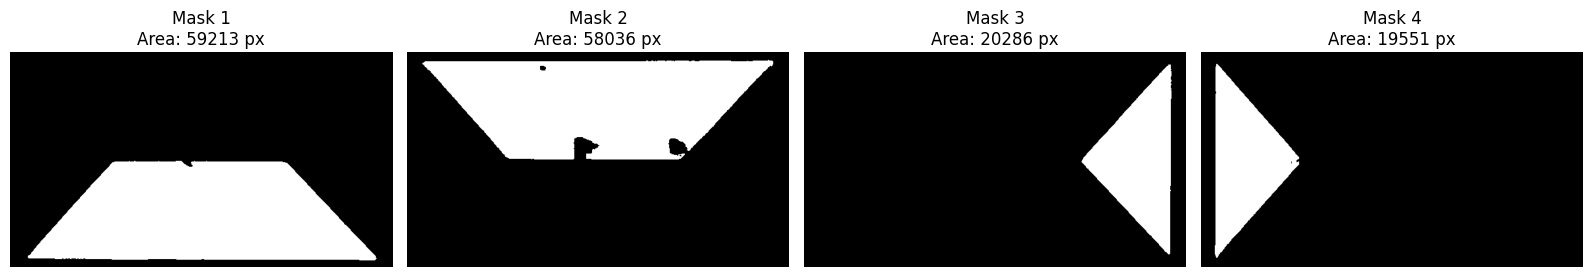

In [ ]:
import matplotlib.pyplot as plt

# 1. Sort by area (Largest to Smallest)
sorted_results = sorted(sam_result, key=lambda x: x['area'], reverse=True)

# 2. Slice to keep only the top 5
top_masks = sorted_results[1:5]

# 3. Plotting using Matplotlib
plt.figure(figsize=(20, 5)) # Set the size of the whole figure (Width, Height)

for i, result in enumerate(top_masks):
    mask = result['segmentation']
    area_count = result['area']

    # Create a subplot for each mask (1 row, 5 columns, current index)
    plt.subplot(1, 5, i + 1)

    # Show the mask (cmap='gray' makes it black & white)
    plt.imshow(mask, cmap='gray')

    # Add the Area as the title of the individual plot
    plt.title(f"Mask {i+1}\nArea: {area_count} px")

    # Hide the axis numbers for a cleaner look
    plt.axis('off')

plt.tight_layout()
plt.show()

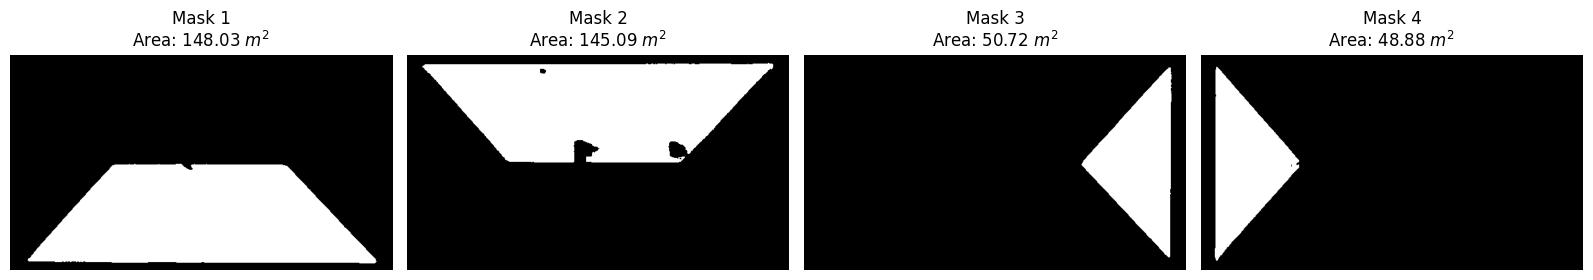

In [ ]:
import matplotlib.pyplot as plt

# --- STEP 1: DEFINE YOUR SCALE ---
# specific to your image source.
# Example: If 1 pixel represents 5 centimeters, then:
# 5 cm = 0.05 meters
meters_per_pixel = 0.05

# --- STEP 2: SORT & FILTER ---
# Sort by pixel area (Largest to Smallest)
sorted_results = sorted(sam_result, key=lambda x: x['area'], reverse=True)
# Keep top 5
top_masks = sorted_results[1:5]

# --- STEP 3: PLOT WITH CONVERSION ---
plt.figure(figsize=(20, 5))

for i, result in enumerate(top_masks):
    mask = result['segmentation']
    pixel_area = result['area']

    # Calculate Real Area
    # We square the scale because Area = Length x Width
    real_area = pixel_area * (meters_per_pixel ** 2)

    plt.subplot(1, 5, i + 1)
    plt.imshow(mask, cmap='gray')

    # Display the Real Area in the title
    plt.title(f"Mask {i+1}\nArea: {real_area:.2f} $m^2$")
    plt.axis('off')

plt.tight_layout()
plt.show()

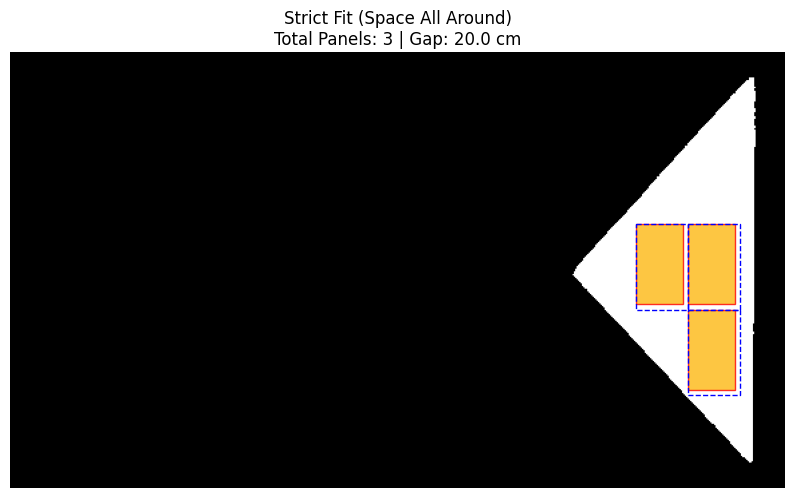

Total Panels Fitted: 3
Total Generating Area: 15.75 m^2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- CONFIGURATION ---
METERS_PER_PIXEL = 0.05  # Example: 1 pixel = 5cm
PANEL_HEIGHT_M = 3.0
PANEL_WIDTH_M = 1.75
GAP_M = 0.2             # 20 cm spacing

# --- PIXEL CALCULATIONS ---
panel_h_px = int(PANEL_HEIGHT_M / METERS_PER_PIXEL)
panel_w_px = int(PANEL_WIDTH_M / METERS_PER_PIXEL)

# Force minimum 1 pixel gap for visibility (since 2cm is very small)
raw_gap = GAP_M / METERS_PER_PIXEL
gap_px = max(1, int(raw_gap)) if GAP_M > 0 else 0

# Use the same mask as your example
target_mask = top_masks[2]['segmentation']

def calculate_panels_strict(mask, p_h, p_w, gap):
    rows, cols = mask.shape
    valid_panels = []

    # stride: The step size includes the panel AND the gap
    step_y = p_h + gap
    step_x = p_w + gap

    for y in range(0, rows - step_y, step_y):
        for x in range(0, cols - step_x, step_x):

            # --- THE FIX IS HERE ---
            # We define the TOTAL FOOTPRINT (Panel + Gap)
            # We assume the gap must also sit on the roof (cannot hang off)
            footprint_h = p_h + gap
            footprint_w = p_w + gap

            roi_total = mask[y : y + footprint_h, x : x + footprint_w]

            # Check if the ENTIRE footprint (Panel + Gap) is on white pixels
            # If the gap hits a black pixel (edge), we reject it.
            if roi_total.shape == (footprint_h, footprint_w) and np.all(roi_total):
                valid_panels.append((x, y))

    return valid_panels

# Run calculation
placed_panels = calculate_panels_strict(target_mask, panel_h_px, panel_w_px, gap_px)

# --- VISUALIZATION ---
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(target_mask, cmap='gray')

for (x, y) in placed_panels:
    # 1. Draw the Panel (Yellow)
    rect_panel = patches.Rectangle(
        (x, y), panel_w_px, panel_h_px,
        linewidth=1, edgecolor='red', facecolor='#FDB813', alpha=0.8
    )
    # 2. Draw the Gap Area (Blue Outline around the panel)
    rect_gap = patches.Rectangle(
        (x, y), panel_w_px + gap_px, panel_h_px + gap_px,
        linewidth=1, edgecolor='blue', facecolor='none', linestyle='--'
    )
    ax.add_patch(rect_panel)
    ax.add_patch(rect_gap)

# Stats
total_fit = len(placed_panels)
# Area of actual panels (not including gaps)
total_area = total_fit * (PANEL_WIDTH_M * PANEL_HEIGHT_M)

ax.set_title(f"Strict Fit (Space All Around)\nTotal Panels: {total_fit} | Gap: {GAP_M*100} cm")
plt.axis('off')
plt.show()

print(f"Total Panels Fitted: {total_fit}")
print(f"Total Generating Area: {total_area:.2f} m^2")

File found. Processing: /content/image.png
Running SAM Automatic Mask Generation...
Found 27 total segments.
Analyzing 4 largest distinct roof sections.

--- Placement Analysis Results ---

[Section 1]
  > Roof Section Area: 148.30 m²
  > Panel Dimensions Used: 3.0m x 1.75m
  > Panel Quantity Fitted: 15
  > Total Area Covered by Panels: 78.75 m²

[Section 2]
  > Roof Section Area: 146.13 m²
  > Panel Dimensions Used: 3.0m x 1.75m
  > Panel Quantity Fitted: 11
  > Total Area Covered by Panels: 57.75 m²

[Section 3]
  > Roof Section Area: 50.72 m²
  > Panel Dimensions Used: 1.75m x 3.0m
  > Panel Quantity Fitted: 3
  > Total Area Covered by Panels: 15.75 m²

[Section 4]
  > Roof Section Area: 48.88 m²
  > Panel Dimensions Used: 1.75m x 3.0m
  > Panel Quantity Fitted: 2
  > Total Area Covered by Panels: 10.50 m²


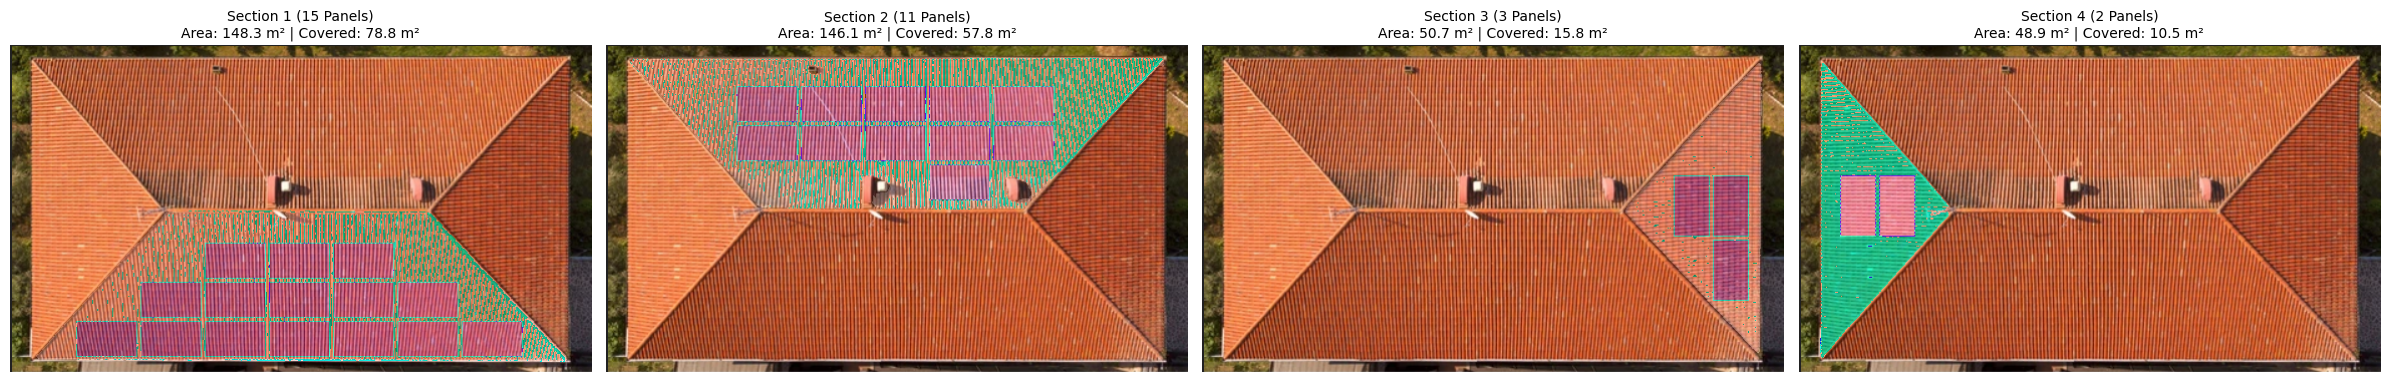

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from typing import List, Dict, Any, Tuple

# --- Configuration Constants ---
# SAM Model Configuration
MODEL_TYPE = "vit_h"  # Vision Transformer Huge
MODEL_URL = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
MODEL_PATH = "sam_vit_h_4b8939.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Solar Panel & Scaling Parameters
PIXEL_SCALE_M = 0.05      # 1 pixel = 5 cm (0.05 meters)
PANEL_WIDTH_M = 3.0       # Panel long side in meters
PANEL_HEIGHT_M = 1.75     # Panel short side in meters
GAP_M = 0.2               # Required gap around panels in meters

# Visualization Color (New)
# BGR format: Deep Blue for a realistic solar panel look
PANEL_COLOR_BGR = (130, 0, 0)

# --- Setup and Initialization ---

def setup_sam_model() -> SamAutomaticMaskGenerator:
    """Downloads model weights (if not present) and initializes the SAM mask generator."""
    import torch

    if not os.path.exists(MODEL_PATH):
        print(f"Downloading SAM model weights to {MODEL_PATH}...")
        # Note: This line requires internet access for download
        torch.hub.download_url_to_file(MODEL_URL, MODEL_PATH)
        print("Download complete.")

    sam = sam_model_registry[MODEL_TYPE](checkpoint=MODEL_PATH).to(DEVICE)
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=16,
        pred_iou_thresh=0.86,
        stability_score_thresh=0.92,
        box_nms_thresh=0.7
    )
    return mask_generator

# --- Placement Helper Function ---

def _place_panels_in_orientation(
    mask: np.ndarray,
    panel_w_m: float,
    panel_h_m: float,
    gap_m: float,
    scale_m: float
) -> Tuple[int, List[Tuple[Tuple[int, int], Tuple[int, int]]]]:
    """
    Core logic for placement given a specific panel width and height.
    Returns panel count and coordinates.
    """

    # Convert real-world dimensions to pixel dimensions
    panel_w_px = int(panel_w_m / scale_m)
    panel_h_px = int(panel_h_m / scale_m)
    gap_px = int(gap_m / scale_m)

    # Footprint includes the panel and the required gap
    footprint_w = panel_w_px + gap_px
    footprint_h = panel_h_px + gap_px

    H, W = mask.shape
    placed_panels = []

    # Simple check to avoid errors if the mask is too small
    if H < footprint_h or W < footprint_w:
        return 0, []

    panel_count = 0

    # Iterate through the mask dimensions using the footprint size as the step
    for y in range(0, H - footprint_h + 1, footprint_h):
        for x in range(0, W - footprint_w + 1, footprint_w):

            # 1. Define the current placement region (panel + gap)
            footprint_slice = mask[y:y + footprint_h, x:x + footprint_w]

            # 2. Check for mask boundary constraint (Strict Fit)
            # The entire footprint must be INSIDE the segmented area (all values must be True/1)
            is_valid_placement = footprint_slice.all()

            if is_valid_placement:
                panel_count += 1

                # Store the panel's coordinates (for visualization)
                # We save the inner panel area, excluding the gap
                panel_x1 = x + gap_px // 2
                panel_y1 = y + gap_px // 2
                panel_x2 = panel_x1 + panel_w_px
                panel_y2 = panel_y1 + panel_h_px

                placed_panels.append(((panel_x1, panel_y1), (panel_x2, panel_y2)))

    return panel_count, placed_panels


# --- Main Placement Logic (Dual Orientation) ---

def strict_fit_placement(
    mask: np.ndarray,
    panel_w_m: float,
    panel_h_m: float,
    gap_m: float,
    scale_m: float
) -> Tuple[int, np.ndarray, float, float]:
    """
    Tests both horizontal and vertical orientations and returns the best fit.
    """
    H, W = mask.shape

    # Option 1: Horizontal Orientation (Long side parallel to x-axis)
    count_horiz, panels_horiz = _place_panels_in_orientation(
        mask, panel_w_m, panel_h_m, gap_m, scale_m
    )

    # Option 2: Vertical Orientation (Short side parallel to x-axis)
    count_vert, panels_vert = _place_panels_in_orientation(
        mask, panel_h_m, panel_w_m, gap_m, scale_m # Swapping W and H for vertical
    )

    # Determine Best Orientation
    if count_vert > count_horiz:
        best_count = count_vert
        best_panels = panels_vert
        final_panel_w = panel_h_m # The short side is now the width
        final_panel_h = panel_w_m # The long side is now the height
    else:
        # Default to horizontal if counts are equal or horizontal is better
        best_count = count_horiz
        best_panels = panels_horiz
        final_panel_w = panel_w_m
        final_panel_h = panel_h_m

    # --- Visualization Generation ---
    vis_img = np.zeros((H, W, 3), dtype=np.uint8)
    vis_img[mask == 1] = [100, 100, 100]  # Light gray for the roof section (BGR)

    # Draw placed panels (Deep Blue)
    for (x1, y1), (x2, y2) in best_panels:
        # Panel area (Deep Blue BGR)
        vis_img = cv2.rectangle(vis_img, (x1, y1), (x2, y2), PANEL_COLOR_BGR, -1)
        # Panel outline (White)
        vis_img = cv2.rectangle(vis_img, (x1, y1), (x2, y2), (255, 255, 255), 1)

    return best_count, vis_img, final_panel_w, final_panel_h

# --- Main Workflow ---

def process_roof_image(image_path: str):
    """
    Main function to process the image, segment, select roof sections,
    and perform solar panel placement.
    """
    try:
        # Load Model
        mask_generator = setup_sam_model()
    except Exception as e:
        # Use simple print for debugging in notebook environments
        print(f"Error during SAM model setup. Check dependencies and GPU: {e}")
        return

    # Load Image
    if not os.path.exists(image_path):
        print(f"Error: Image file not found at {image_path}")
        return

    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        print("Error: Could not load image. Check path and file format.")
        return

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # 1. Perform Segmentation
    print("Running SAM Automatic Mask Generation...")
    masks = mask_generator.generate(image_rgb)
    print(f"Found {len(masks)} total segments.")

    # 2. Sort and Select Roof Sections
    masks.sort(key=lambda x: x['area'], reverse=True)

    # Neglect the largest segment (index 0) and select up to the next 4
    target_masks = masks[1:5]

    if not target_masks:
        print("Could not identify any distinct roof sections after neglecting the largest segment.")
        return

    print(f"Analyzing {len(target_masks)} largest distinct roof sections.")

    # Create a figure for combined output
    num_sections = len(target_masks)
    fig, axes = plt.subplots(1, num_sections, figsize=(6 * num_sections, 6))
    if num_sections == 1:
        axes = [axes]

    print("\n--- Placement Analysis Results ---")

    for i, mask_data in enumerate(target_masks):
        mask = mask_data['segmentation']

        # 3. Apply Strict Fit Placement (Dual Orientation Test)
        panel_count, placement_vis, final_panel_w, final_panel_h = strict_fit_placement(
            mask, PANEL_WIDTH_M, PANEL_HEIGHT_M, GAP_M, PIXEL_SCALE_M
        )

        # 4. Calculate Metrics
        roof_area_px = mask.sum()
        roof_area_m2 = roof_area_px * (PIXEL_SCALE_M ** 2)

        panel_area_m2 = final_panel_w * final_panel_h
        total_panel_area_m2 = panel_count * panel_area_m2

        # 5. Display Results
        section_name = f"Section {i+1}"

        print(f"\n[{section_name}]")
        print(f"  > Roof Section Area: {roof_area_m2:.2f} m²")
        print(f"  > Panel Dimensions Used: {final_panel_w}m x {final_panel_h}m")
        print(f"  > Panel Quantity Fitted: {panel_count}")
        print(f"  > Total Area Covered by Panels: {total_panel_area_m2:.2f} m²")

        # Overlay panel placement onto the original image
        alpha = 0.5
        combined_vis = image_rgb.copy()

        # The placement_vis is BGR, need to convert to RGB for matplotlib display
        placement_vis_rgb = cv2.cvtColor(placement_vis, cv2.COLOR_BGR2RGB)

        # Blend the visualization overlay with the original image
        combined_vis = cv2.addWeighted(
            combined_vis.astype(float), 1.0,
            placement_vis_rgb.astype(float), alpha, 0.0
        ).astype(np.uint8)

        # Set up plot title and image
        axes[i].imshow(combined_vis)
        axes[i].set_title(
            f"{section_name} ({panel_count} Panels)\nArea: {roof_area_m2:.1f} m² | Covered: {total_panel_area_m2:.1f} m²",
            fontsize=10
        )
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# --- Execution ---
if __name__ == "__main__":
    import torch

    # -----------------------------------------------------------
    # *** USER INPUT REQUIRED ***
    # Set this to the actual path of your image file.
    # -----------------------------------------------------------
    IMAGE_FILE_PATH = "/content/image.png"

    if os.path.exists(IMAGE_FILE_PATH):
        print(f"File found. Processing: {IMAGE_FILE_PATH}")
        process_roof_image(IMAGE_FILE_PATH)
    else:
        print(f"!!! ERROR !!!: The file at '{IMAGE_FILE_PATH}' was not found.")
        print("Please check the path and try again.")

Loading SAM model to cuda...
Processing /content/img1.png...
Running segmentation on GPU...
  [Calibration] 1 Pixel = 0.0968 meters

--- Engineering Report ---
Section 1: Placed 85 panels (38.25 kW)


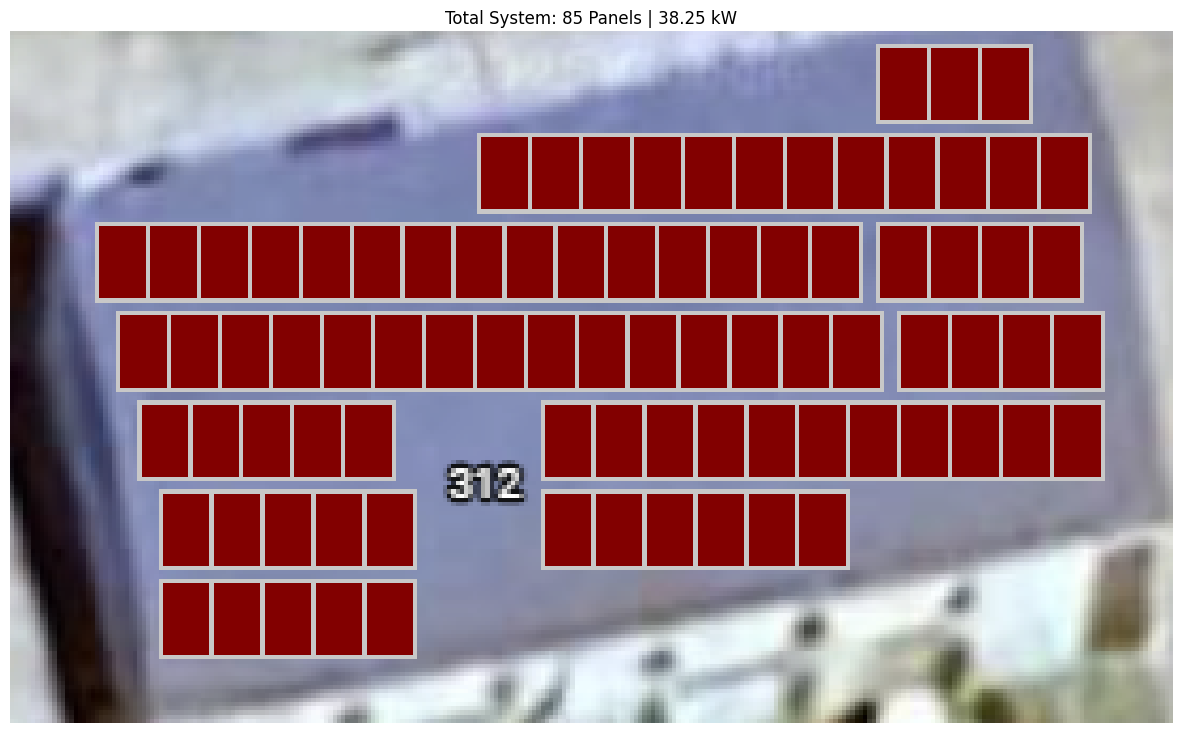

In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from dataclasses import dataclass
from typing import List, Tuple, Dict

# --- 1. HARDWARE SPECIFICATIONS ---
@dataclass
class HardwareSpecs:
    panel_width_mm: float = 1134
    panel_height_mm: float = 1762
    clamp_mm: float = 20
    end_cap_mm: float = 32
    edge_setback_mm: float = 500

# --- 2. INPUT DATA ---
@dataclass
class SiteData:
    image_path: str
    real_roof_area_m2: float
    azimuth_degrees: float = 180.0

# --- 3. THE PLANNER ENGINE ---
class SolarEngineer:
    def __init__(self):
        # FORCE CUDA - No Fallbacks
        if not torch.cuda.is_available():
            raise RuntimeError("CUDA is not available! Check your runtime settings.")

        self.device = "cuda"

        # 1. Clear GPU Cache to fix "Invalid Argument" errors from previous runs
        torch.cuda.empty_cache()

        self.specs = HardwareSpecs()
        self.model = self._load_model()
        self.gsd = 0.0

    def _load_model(self):
        """Initializes the SAM Model strictly on GPU."""
        checkpoint = "sam_vit_h_4b8939.pth"
        if not os.path.exists(checkpoint):
            print("Downloading weights...")
            url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
            torch.hub.download_url_to_file(url, checkpoint)

        print(f"Loading SAM model to {self.device}...")

        # Load directly to device
        sam = sam_model_registry["vit_h"](checkpoint=checkpoint)
        sam.to(device=self.device)

        return SamAutomaticMaskGenerator(
            model=sam,
            points_per_side=32,
            pred_iou_thresh=0.88,
            stability_score_thresh=0.95,
            crop_n_layers=0
        )

    def calibrate_scale(self, total_mask_pixels: int, real_area_m2: float) -> float:
        if total_mask_pixels == 0: return 0.0
        self.gsd = np.sqrt(real_area_m2 / total_mask_pixels)
        print(f"  [Calibration] 1 Pixel = {self.gsd:.4f} meters")
        return self.gsd

    def mm_to_px(self, mm_value: float) -> int:
        meters = mm_value / 1000.0
        return int(round(meters / self.gsd))

    def get_rotated_rect(self, center: Tuple[int, int], w: int, h: int, angle: float):
        rect = ((center[0], center[1]), (w, h), angle)
        box = cv2.boxPoints(rect)
        return box.astype(np.int32)

    def calculate_row_length_px(self, num_panels: int) -> int:
        w_mm = self.specs.panel_width_mm
        c_mm = self.specs.clamp_mm
        e_mm = self.specs.end_cap_mm
        total_mm = (num_panels * w_mm) + ((num_panels + 1) * c_mm) + (2 * e_mm)
        return self.mm_to_px(total_mm)

    def place_panels(self, roof_mask: np.ndarray, azimuth: float):
        H, W = roof_mask.shape
        occupied = np.zeros((H, W), dtype=np.uint8)
        panel_polygons = []

        p_h_px = self.mm_to_px(self.specs.panel_height_mm)
        p_w_px = self.mm_to_px(self.specs.panel_width_mm)
        row_spacing_px = self.mm_to_px(300)

        setback_px = self.mm_to_px(self.specs.edge_setback_mm)
        kernel = np.ones((setback_px, setback_px), np.uint8)

        # Ensure mask is uint8 (0 or 255)
        roof_mask_uint8 = (roof_mask > 0).astype(np.uint8) * 255
        safe_zone = cv2.erode(roof_mask_uint8, kernel, iterations=1)

        y_idxs, x_idxs = np.where(safe_zone > 0)
        if len(y_idxs) == 0: return [], 0.0

        y_min, y_max = y_idxs.min(), y_idxs.max()
        x_min, x_max = x_idxs.min(), x_idxs.max()

        total_panels = 0
        rot_angle = azimuth - 180
        step_y = p_h_px + row_spacing_px

        for y in range(y_min, y_max, step_y):
            for x in range(x_min, x_max, 5):

                # Try to fit largest possible row (up to 15 panels)
                for n_panels in range(15, 0, -1):

                    row_len_px = self.calculate_row_length_px(n_panels)

                    center_x = x + row_len_px // 2
                    center_y = y + p_h_px // 2

                    poly = self.get_rotated_rect((center_x, center_y), row_len_px, p_h_px, rot_angle)

                    row_mask = np.zeros_like(safe_zone)
                    cv2.fillPoly(row_mask, [poly], 255)

                    # 1. Check Bounds
                    if cv2.countNonZero(cv2.bitwise_and(row_mask, safe_zone)) != cv2.countNonZero(row_mask):
                        continue

                    # 2. Check Overlap
                    if cv2.countNonZero(cv2.bitwise_and(row_mask, occupied)) > 0:
                        continue

                    # --- VALID PLACEMENT ---
                    cv2.fillPoly(occupied, [poly], 255)

                    current_x_offset = -row_len_px // 2 + self.mm_to_px(self.specs.end_cap_mm)

                    for _ in range(n_panels):
                        p_center_x = center_x + current_x_offset + p_w_px // 2
                        p_poly = self.get_rotated_rect((p_center_x, center_y), p_w_px, p_h_px, rot_angle)
                        panel_polygons.append(p_poly)
                        current_x_offset += p_w_px + self.mm_to_px(self.specs.clamp_mm)

                    total_panels += n_panels
                    break

        return panel_polygons, total_panels

    def run_pipeline(self, data: SiteData):
        print(f"Processing {data.image_path}...")
        img = cv2.imread(data.image_path)
        if img is None:
            print("Error: Could not read image.")
            return

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        print("Running segmentation on GPU...")
        masks = self.model.generate(img_rgb)

        # Sort and Filter
        masks.sort(key=lambda x: x['area'], reverse=True)
        target_masks = masks[0:1]

        if not target_masks:
            print("No valid roof sections found.")
            return

        # Calibrate Scale
        total_mask_pixels = sum([m['area'] for m in target_masks])
        self.calibrate_scale(total_mask_pixels, data.real_roof_area_m2)

        # Visualize
        print("\n--- Engineering Report ---")
        final_vis = img_rgb.copy()
        total_system_panels = 0

        for i, m_data in enumerate(target_masks):
            mask = m_data['segmentation']

            polys, count = self.place_panels(mask, data.azimuth_degrees)
            total_system_panels += count

            for poly in polys:
                cv2.fillPoly(final_vis, [poly], (130, 0, 0)) # Panel Blue
                cv2.polylines(final_vis, [poly], True, (200, 200, 200), 1) # Outline

            panel_power = 450
            section_kw = (count * panel_power) / 1000
            print(f"Section {i+1}: Placed {count} panels ({section_kw} kW)")

        plt.figure(figsize=(15, 10))
        plt.imshow(final_vis)
        plt.title(f"Total System: {total_system_panels} Panels | {total_system_panels*0.45:.2f} kW")
        plt.axis('off')
        plt.show()

# --- MAIN EXECUTION ---
if __name__ == "__main__":

    # *** USER INPUT ***
    target_image = "/content/img1.png"

    input_data = SiteData(
        image_path=target_image,
        real_roof_area_m2=278.89,
        azimuth_degrees=180.0
    )

    if os.path.exists(input_data.image_path):
        engine = SolarEngineer()
        engine.run_pipeline(input_data)
    else:
        print(f"!!! Error: Image file not found at {input_data.image_path}")

In [14]:
from numba import cuda
device = cuda.get_current_device()
device.reset()